In [ ]:
import os, json

KEYWORDS = ["wait", "alternatively", "hmm"]

def parse_result_file(file_stem: str, path: str, suffix: str = ".json", keywords=KEYWORDS):
    file_path = os.path.join(path, file_stem + suffix)
    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        return None

    correct = 0
    total = 0
    total_len = 0
    total_keyword_count = 0

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            data = json.loads(line)

            if data.get("len", 0) < 10:
                continue

            total += 1
            L = int(data.get("len", 0))
            total_len += L

            if data.get("correct", False):
                correct += 1

            text = (data.get("generated_text", "") or "").lower()
            for kw in keywords:
                total_keyword_count += text.count(kw)

    if total == 0:
        return None

    return {
        "acc": correct / total,
        "avg_len": total_len / total,
        "wait_count": total_keyword_count,
        "n": total,
    }


def parse_tag_budget(file_stem: str, model: str):
    if "begin" in file_stem:
        tag = "begin"
    elif "reason" in file_stem:
        tag = "reason"
    elif "less_think" in file_stem:
        tag = "less_think"
    else:
        tag = "standard"

    budget = None
    if "budget" in file_stem:
        try:
            budget = float(file_stem.split("budget")[-1])
        except Exception:
            budget = None

    if "_False__budget1.0" in file_stem:
        budget = 0.0

    return tag, budget


def collect_results_dict(model: str, files, path: str, suffix: str = ".json", keywords=KEYWORDS):
    """
    输出 dict: results[(tag, budget)] = {"acc":..., "avg_len":..., "wait_count":..., "n":...}
    """
    results = {}
    for file_stem in files:
        metrics = parse_result_file(file_stem, path=path, suffix=suffix, keywords=keywords)
        if metrics is None:
            continue

        tag, budget = parse_tag_budget(file_stem, model=model)

        key = (tag, budget)
        if key in results:
            print(f"[WARN] duplicate key {key} from file {file_stem}. Overwriting.")
        results[key] = metrics

        print(f"{key} -> acc={metrics['acc']:.3f}, avg_len={metrics['avg_len']:.1f}, wait={metrics['wait_count']}  ({file_stem})")

    return results

In [ ]:
def extract_standard_curve(results_dict):
    budgets = []
    accs = []
    avg_lens = []

    for (tag, budget), metrics in results_dict.items():
        if tag != "standard":
            continue
        if budget is None:
            continue

        budgets.append(budget)
        accs.append(metrics["acc"])
        avg_lens.append(metrics["avg_len"])

    sorted_idx = sorted(range(len(budgets)), key=lambda i: budgets[i])
    budgets = [budgets[i] for i in sorted_idx]
    accs = [accs[i] for i in sorted_idx]
    avg_lens = [avg_lens[i] for i in sorted_idx]

    return budgets, accs, avg_lens



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _auto_ylim(values, pad_ratio=0.05, hard_clip=None):
    v = np.asarray(values, dtype=float)
    vmin, vmax = float(np.min(v)), float(np.max(v))

    if np.isclose(vmin, vmax):
        delta = 0.5 if vmax == 0 else abs(vmax) * 0.1
        vmin, vmax = vmin - delta, vmax + delta

    span = vmax - vmin
    vmin2 = vmin - span * pad_ratio
    vmax2 = vmax + span * pad_ratio

    if hard_clip is not None:
        lo, hi = hard_clip
        vmin2 = max(vmin2, lo)
        vmax2 = min(vmax2, hi)

    return vmin2, vmax2


def plot_standard_budget_curve_acl(
    budgets,
    accs,
    avg_lens,
    model,
    dataset,
    pdf_path=None,
    title=None
):
    budgets = np.asarray(budgets, dtype=float)
    accs = np.asarray(accs, dtype=float) * 100.0
    avg_lens = np.asarray(avg_lens, dtype=float)

    c1 = "#1f77b4"   
    c2 = "#d62728"  

    fig, ax1 = plt.subplots(figsize=(4.5, 2))

    l1, = ax1.plot(
        budgets, accs,
        marker="o",
        linewidth=2.0,
        markersize=7,
        label="Accuracy",
        color=c1
    )
    ax1.set_xlabel("Budget")
    ax1.set_ylabel("Accuracy", color=c1)
    ax1.tick_params(axis="y", colors=c1)
    ax1.spines["left"].set_color(c1)

    y1_lo, y1_hi = _auto_ylim(accs, pad_ratio=0.06, hard_clip=None)
    ax1.set_ylim(y1_lo, y1_hi)

    ax2 = ax1.twinx()
    l2, = ax2.plot(
        budgets, avg_lens,
        marker="s",
        linewidth=2.0,
        linestyle="--",
        markersize=7,
        label="Avg Length",
        color=c2
    )
    ax2.set_ylabel("Avg Length", color=c2)
    ax2.tick_params(axis="y", colors=c2)
    ax2.spines["right"].set_color(c2)

    y2_lo, y2_hi = _auto_ylim(avg_lens, pad_ratio=0.06, hard_clip=None)
    ax2.set_ylim(y2_lo, y2_hi)

    ax1.set_xticks(budgets)
    ax1.set_xticklabels([f"{b:g}" for b in budgets])

    ax1.grid(True, axis="y", linestyle="--", linewidth=0.8, alpha=0.35)
    ax1.grid(False, axis="x")

    handles = [l1, l2]
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc="best", frameon=False)

    # # ---- Title ----
    # if title is None:
    #     title = f"{model} on {dataset}"
    # ax1.set_title(title)

    fig.tight_layout()

    if pdf_path is not None:
        fig.savefig(pdf_path, bbox_inches="tight", dpi=600)

    plt.show()

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "MATH-500", 5, "Qwen3-14B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}

('begin', 1.0) -> acc=0.931, avg_len=2805.5, wait=23024  (Qwen3-14B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.921, avg_len=2589.8, wait=20933  (Qwen3-14B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.933, avg_len=2655.0, wait=21249  (Qwen3-14B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.863, avg_len=899.1, wait=329  (Qwen3-14B_False__budget1.0)
('standard', 0.1) -> acc=0.874, avg_len=1563.3, wait=10252  (Qwen3-14B_True__budget0.1)
('standard', 0.2) -> acc=0.892, avg_len=1879.9, wait=16225  (Qwen3-14B_True__budget0.2)
('standard', 0.3) -> acc=0.916, avg_len=2170.8, wait=22293  (Qwen3-14B_True__budget0.3)
('standard', 0.4) -> acc=0.922, avg_len=2472.7, wait=27339  (Qwen3-14B_True__budget0.4)
('standard', 0.5) -> acc=0.928, avg_len=2852.9, wait=33080  (Qwen3-14B_True__budget0.5)
('standard', 0.6) -> acc=0.936, avg_len=3244.6, wait=38788  (Qwen3-14B_True__budget0.6)
('standard', 1.0) -> acc=0.944, avg_len=4904.3, wait=59288  (Qwen3-14B_True__budget1.0)


## verification

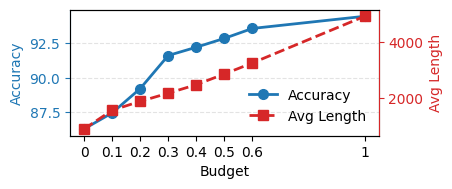

In [23]:
budgets, accs, avg_lens = extract_standard_curve(results_dict)

plot_standard_budget_curve_acl(
    budgets, accs, avg_lens,
    model=model,
    dataset=dataset,
    pdf_path=f"./budget/standard/{dataset}-{n}-{model}-axis-acl.pdf"
)